[intro and member names etc]

# Final/base HOG and SVM

## Setup

In [1]:
# Import required libraries

import numpy as np
from matplotlib import pyplot as plt
from skimage import color
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from skimage import color, io
import shutil
import os
from PIL import Image
import joblib

# Checking it can read the data
# from subprocess import check_output
# print(check_output(["ls", "data/raw/human"]).decode("utf8"))

from ablation_hog import custom_hog

In [5]:
# Defining image dimensions for HOG
img_width = 64
img_height = 128

In [3]:
# Delete the 'processed' folder if it exists
processed_dir = "data/processed/"

if os.path.exists(processed_dir):
    shutil.rmtree(processed_dir)
    print(f"Deleted folder: {processed_dir}")
else:
    print(f"No folder to delete at: {processed_dir}")

Deleted folder: data/processed/


## Data processing

### Resizing and centre cropping human image examples

Starts with ~18000 images and ends with ~12000 images.

In [4]:
input_folder = "data/raw/human"
output_folder = "data/processed/human"
os.makedirs(output_folder, exist_ok=True)

def resize_and_center_crop(img, target_width=img_width, target_height=img_height):
    # Resize while keeping aspect ratio, but ensure the image is at least target size in both dimensions
    img_ratio = img.width / img.height
    target_ratio = target_width / target_height

    if img_ratio > target_ratio:
        # Image is wider than target — resize based on height
        new_height = target_height
        new_width = int(target_height * img_ratio)
    else:
        # Image is taller or narrower than target — resize based on width
        new_width = target_width
        new_height = int(target_width / img_ratio)

    img_resized = img.resize((new_width, new_height), Image.LANCZOS)

    # Center crop to target size
    left = (img_resized.width - target_width) // 2
    top = (img_resized.height - target_height) // 2
    right = left + target_width
    bottom = top + target_height

    return img_resized.crop((left, top, right, bottom))

for filename in os.listdir(input_folder):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join(input_folder, filename)
        img = Image.open(path)
        # img = Image.open(path).convert("RGB")
        cropped = resize_and_center_crop(img)
        cropped.save(os.path.join(output_folder, filename))

### Downscaling and obtaining non-overlapping crops of nonhuman images

Starts with 1218 nonhuman images and ends with ~13000 unique nonhuman images.

In [5]:
input_folder = "data/raw/nonhuman"
output_folder = "data/processed/nonhuman"
os.makedirs(output_folder, exist_ok=True)

crop_id = 0  # Unique filename ID
scale_factor = 4 / 5  # Downsize images before cropping

for fname in os.listdir(input_folder):
    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        path = os.path.join(input_folder, fname)
        img = Image.open(path)
        # img = Image.open(path).convert("RGB")
        # width, height = img.size

        # Resize image to 2/3 of original size
        new_width = int(img.width * scale_factor)
        new_height = int(img.height * scale_factor)
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)

        # Calculate number of non-overlapping crops that fit
        num_x = new_width // img_width
        num_y = new_height // img_height

        for y in range(num_y):
            for x in range(num_x):
                left = x * img_width
                top = y * img_height
                right = left + img_width
                bottom = top + img_height

                crop = img.crop((left, top, right, bottom))
                out_path = os.path.join(output_folder, f"nonhuman_{crop_id}.jpg")
                crop.save(out_path)
                crop_id += 1

print(f"Saved {crop_id} non-overlapping 64x128 crops to {output_folder}")

Saved 13717 non-overlapping 64x128 crops to data/processed/nonhuman


## HOG and SVM training and evaluation

In [ ]:
image_size = (img_width, img_height)
human_dir = "data/processed/human"
nonhuman_dir = "data/processed/nonhuman"

features = []
labels = []

def extract_hog_features(img_path):
    img = Image.open(img_path).convert("L").resize(image_size)
    img_np = np.array(img)
    
    hog_features = custom_hog(img_np, orientations=9, pixels_per_cell=(8, 8),
                            block_norm='l2hys', transform_sqrt=True,
                            feature_vector=True, unsigned=True, gradient='scharr',
                            gamma=1.0, gaussian_sigma=0.0)

    # hog_features = hog(
    #     img_np,
    #     orientations=9,
    #     pixels_per_cell=(8, 8),
    #     cells_per_block=(2, 2),
    #     block_norm='L2-Hys',
    #     feature_vector=True)

    return hog_features

# Process human images (label = 1)
for fname in os.listdir(human_dir):
    if fname.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(human_dir, fname)
        features.append(extract_hog_features(path))
        labels.append(1)

# Process nonhuman images (label = 0)
for fname in os.listdir(nonhuman_dir):
    if fname.lower().endswith((".jpg", ".png", ".jpeg")):
        path = os.path.join(nonhuman_dir, fname)
        features.append(extract_hog_features(path))
        labels.append(0)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# === CONFIGURATION ===
RUN_GRIDSEARCH = False  # Toggle this to False after finding best C
best_C = 10            # This is what will be used for the final model

# === TRAINING ===
if RUN_GRIDSEARCH:
    print("Running GridSearchCV to find best C...")
    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    svc = SVC(kernel='rbf')
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_C = grid_search.best_params_['C']
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

print(f"\nTraining final model with C={best_C}...")
clf = SVC(C=best_C, kernel='rbf')
clf.fit(X_train, y_train)



Training final model with C=10...


In [8]:
# === EVALUATION ===
print("\nTrain set evaluation:")
y_train_pred = clf.predict(X_train)
print(classification_report(y_train, y_train_pred, digits=4))

print("\nTest set evaluation:")
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred, digits=4))


Train set evaluation:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     10974
           1     1.0000    1.0000    1.0000     12962

    accuracy                         1.0000     23936
   macro avg     1.0000    1.0000    1.0000     23936
weighted avg     1.0000    1.0000    1.0000     23936


Test set evaluation:
              precision    recall  f1-score   support

           0     0.9805    0.9701    0.9753      2743
           1     0.9749    0.9836    0.9793      3241

    accuracy                         0.9774      5984
   macro avg     0.9777    0.9769    0.9773      5984
weighted avg     0.9775    0.9774    0.9774      5984



In [11]:
joblib.dump(clf, 'svm_model.pkl')

['svm_model.pkl']

# Ablation studies

## Study 1: Effect of ...

## Study 2: Effect of ...

## Study 3: Effect of ...

### Visualisation of HOG and other debugging (might be useful later)

0
[0.24485584 0.03250129 0.05814783 ... 0.03887927 0.01072847 0.02250082]


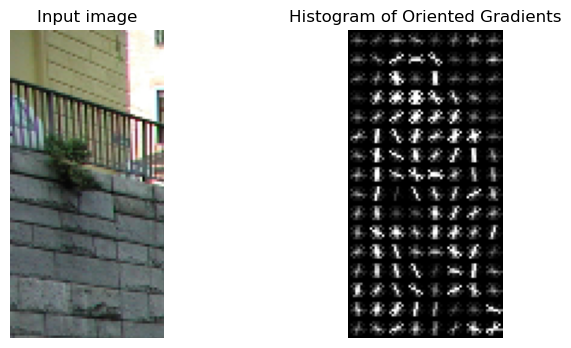

In [8]:
from skimage import data, exposure

# img = Image.open(img_path).convert("L").resize(image_size)


def extract_hog_features(img_path):
    img = Image.open(img_path).convert("L").resize(image_size)
    img_np = np.array(img)
    hog_features, hog_image = hog(
        img_np,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True,
        visualize=True,
        # channel_axis=-1,
    )
    return hog_features, hog_image

print(labels[-1])
hog_features, hog_image = extract_hog_features('data/processed/human/0_8.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

print(hog_features)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

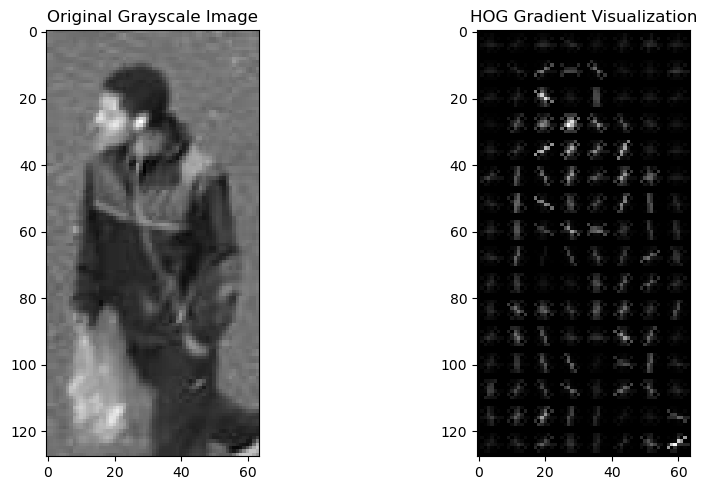

In [9]:
# Load and convert image to grayscale
image = io.imread("data/processed/human/0_8.jpg")  # replace with your path
gray_image = color.rgb2gray(image)

# Compute HOG features and visualization
features, hog_image = hog(
    gray_image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    block_norm='L2-Hys'
)

# Plot original and HOG gradient image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap="gray")
plt.title("Original Grayscale Image")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap="gray")
plt.title("HOG Gradient Visualization")

plt.tight_layout()
plt.show()